## Grouping by temperature bins 
In this file we create a dictionary whose keys are sample names and its entries are dataframes. Each dataframe has rows corresponding to temperature intervals and columns corresponding to mass-to-charge ratios. Then each entry is the integral of the renormalized abundance curve for the given ratio, over the temperature interval.




In [46]:
import pandas as pd
import numpy as np  
import pickle
import random
import matplotlib.pyplot as plt

We load the train_files and val_files dictionary

In [47]:
with open('../Data/train_files.pickle', 'rb') as h:
    train_files = pickle.load(h)

with open('../Data/val_files.pickle', 'rb') as f:
    val_files = pickle.load(f)

train_labels = pd.read_csv("../Data/train_labels.csv",index_col="sample_id")
val_labels = pd.read_csv("../Data/val_labels.csv",index_col="sample_id")

For a collection of samples we plot temperature as a function of time.

In [48]:
random.seed(30175)

samples_list = random.sample(list(train_files.keys()),25)

num_samples = len(samples_list)

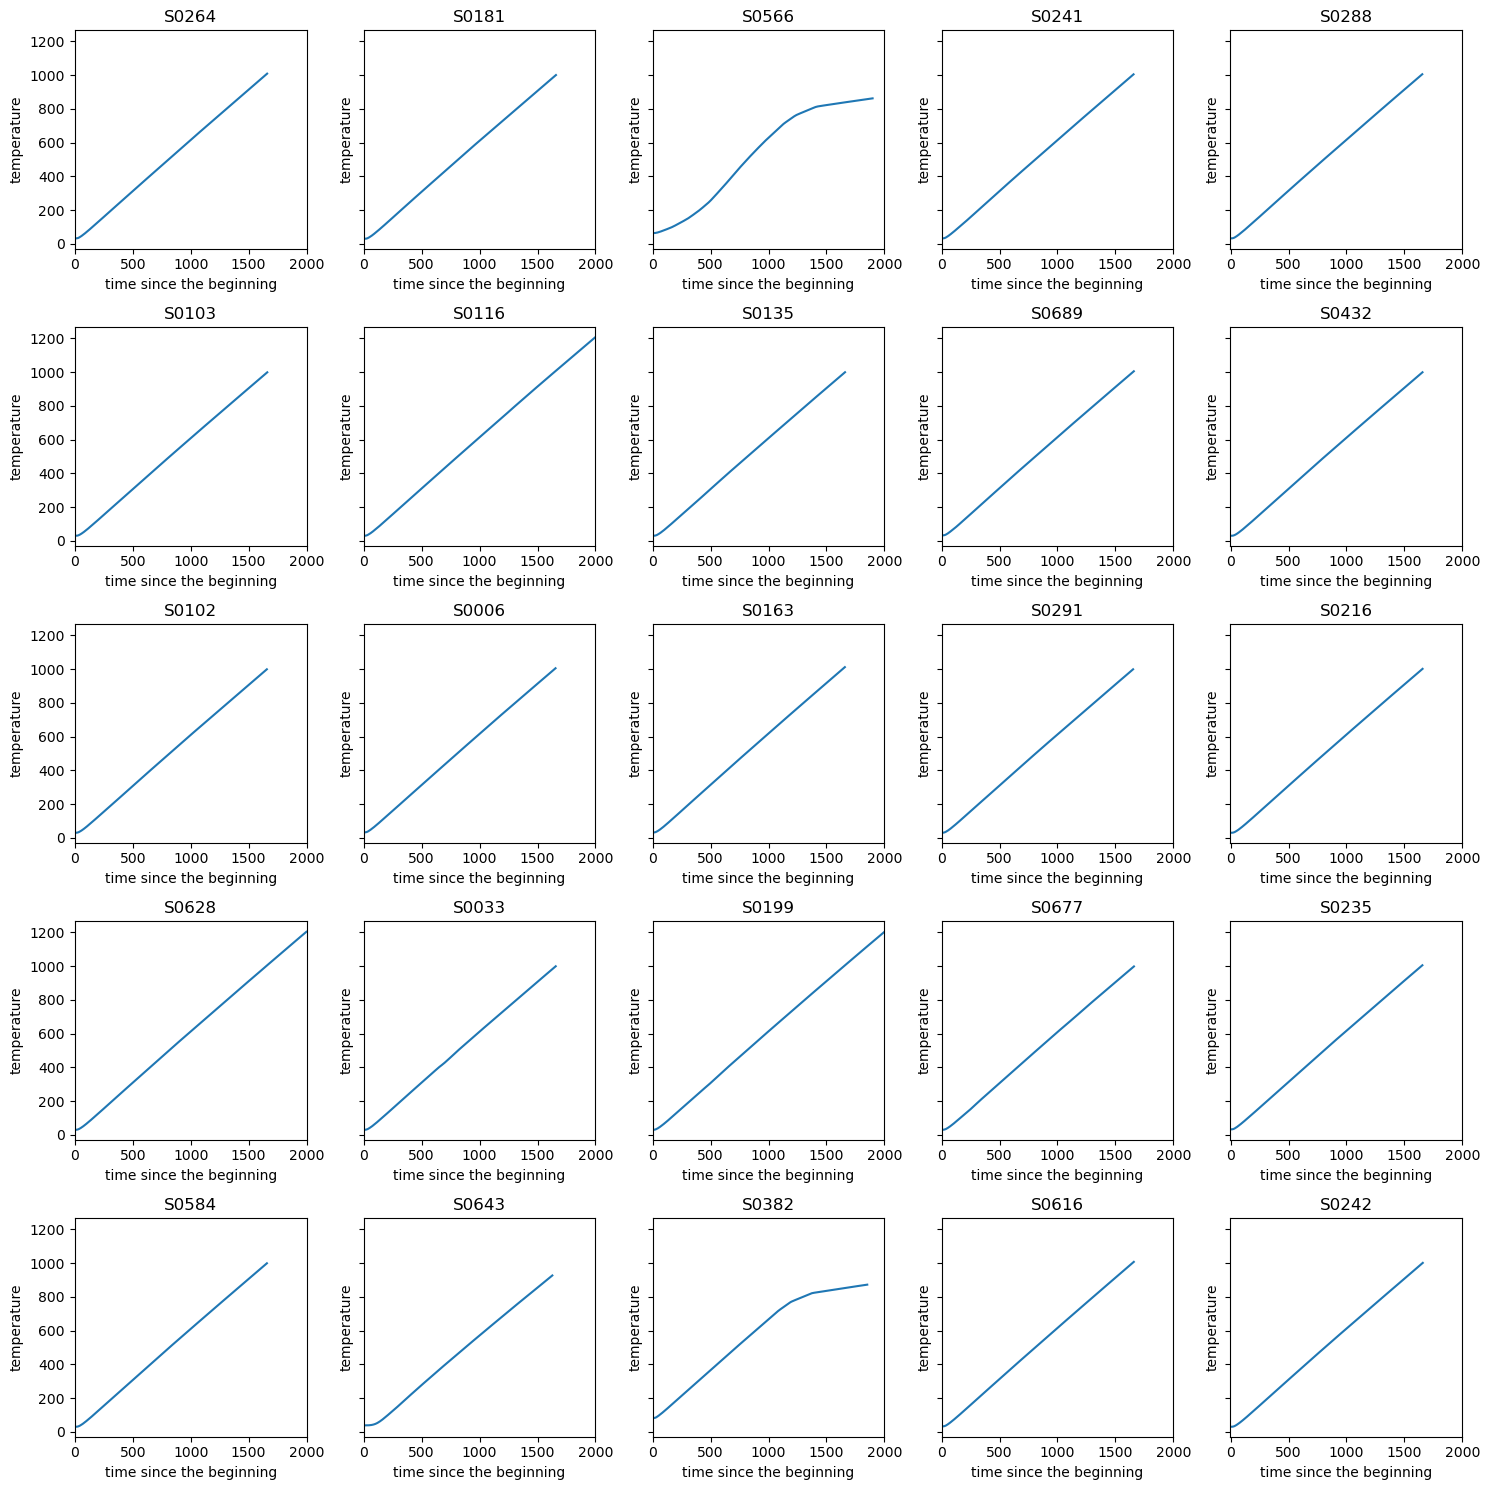

In [49]:
# Create a figure and an array of subplots indexed using axis

fig, ax = plt.subplots(nrows=5,ncols=5,sharey = True,figsize = (15,15))


for i, sample in enumerate(samples_list): 

    df = pd.read_csv(train_files[sample])

    plt.subplot(5,5,i+1)

    plt.plot(df.time,df.temp)
    
    plt.xlim((-1,2000))
    plt.ylim = ((-100,1600))


    
    plt.xlabel('time since the beginning')
    
    plt.ylabel('temperature')
    
    plt.title(sample)



# fig.set_size_inches(14,10)



fig.tight_layout()

plt.show()



## Preprocessing the data

We need to consider the temperature at which the ions come out and look at the relative ratio of the area under the curves at each temperature range.

In [50]:
from preprocess import preprocess # this is the function we wrote in EDA

samples_list = list(train_files.keys()) # we will create a dictionary containing a dataframe for each sample in the train_files list.

# Define temp bins
temp_bin = pd.interval_range(start=-100, end=1500, freq=100)

# Make list to store temp bin labels
index_list = []
for temp in temp_bin:
    index_list.append(str(temp))

x_min = -100
x_max = 1500

num_bins = 16
bin_width = (x_max - x_min) / num_bins

# make a dictionary to store dataframes with area data

DictAreasTrain = {}

# samples_areas = np.zeros(len(samples_list))

# Import trapezoid rule to integrate under curve
from scipy.integrate import simpson, trapezoid

for i, sample in enumerate(samples_list):

    
    # print (np.shape(areas))
    df = pd.read_csv(train_files[sample]) # read the sample file

    df_mod = preprocess(df)

    areas = np.zeros((num_bins, 100)) 

    for mz in range(100):

        df_mz = df_mod[df_mod['m/z'] == mz]

        for j in range(num_bins):
            x_left = x_min + j * bin_width
            x_right = x_left + bin_width
            
            # Make x array by getting values in dataframe between x_left and x_right
            x_array = np.array(df_mz[df_mz['temp'].between(x_left, x_right, inclusive='right')]['temp'])
            y_array = np.array(df_mz[df_mz['temp'].between(x_left, x_right, inclusive='right')]['zero_one_rescale'])

            # Add calculated area to areas array
            areas[j,mz] = trapezoid(y_array, x_array)

        
    # Make dataframe out of areas array and set the index to the temp bins
    areas_df = pd.DataFrame(areas)
    areas_df.index = index_list 

    DictAreasTrain[sample] = areas_df
         
    

Creating the dictionary is slow, so we save it in a file that can be easily accessed.

In [58]:
with open('DictAreasTrain.pickle', 'wb') as f:
    pickle.dump(DictAreasTrain, f)

We now do the same for the val files

In [52]:
from preprocess import preprocess # this is the function we wrote in EDA

samples_list = list(val_files.keys()) # we will create a dictionary containing a dataframe for each sample in the val_files list.

# Define temp bins
temp_bin = pd.interval_range(start=-100, end=1500, freq=100)

# Make list to store temp bin labels
index_list = []
for temp in temp_bin:
    index_list.append(str(temp))

x_min = -100
x_max = 1500

num_bins = 16
bin_width = (x_max - x_min) / num_bins

# make a dictionary to store dataframes with area data

DictAreasVal = {}

# samples_areas = np.zeros(len(samples_list))

# Import trapezoid rule to integrate under curve
from scipy.integrate import simpson, trapezoid

for i, sample in enumerate(samples_list):

    
    # print (np.shape(areas))
    df = pd.read_csv(val_files[sample]) # read the sample file

    df_mod = preprocess(df)

    areas = np.zeros((num_bins, 100)) 

  
    for mz in range(100):

        df_mz = df_mod[df_mod['m/z'] == mz]

        for j in range(num_bins):
            x_left = x_min + j * bin_width
            x_right = x_left + bin_width
            
            # Make x array by getting values in dataframe between x_left and x_right
            x_array = np.array(df_mz[df_mz['temp'].between(x_left, x_right, inclusive='right')]['temp'])
            y_array = np.array(df_mz[df_mz['temp'].between(x_left, x_right, inclusive='right')]['zero_one_rescale'])

            # Add calculated area to areas array
            areas[j,mz] = trapezoid(y_array, x_array)

        
    # Make dataframe out of areas array and set the index to the temp bins
    areas_df = pd.DataFrame(areas)
    areas_df.index = index_list 

    DictAreasVal[sample] = areas_df

In [59]:
with open('DictAreasVal.pickle', 'wb') as f:
    pickle.dump(DictAreasVal, f)

Check the sizes of the dictionaries:

In [57]:
print(len(DictAreasTrain.keys()),len(DictAreasVal.keys()))

754 293


#### Plots of the areas under rescaled abundance curves, split by temperature bin.

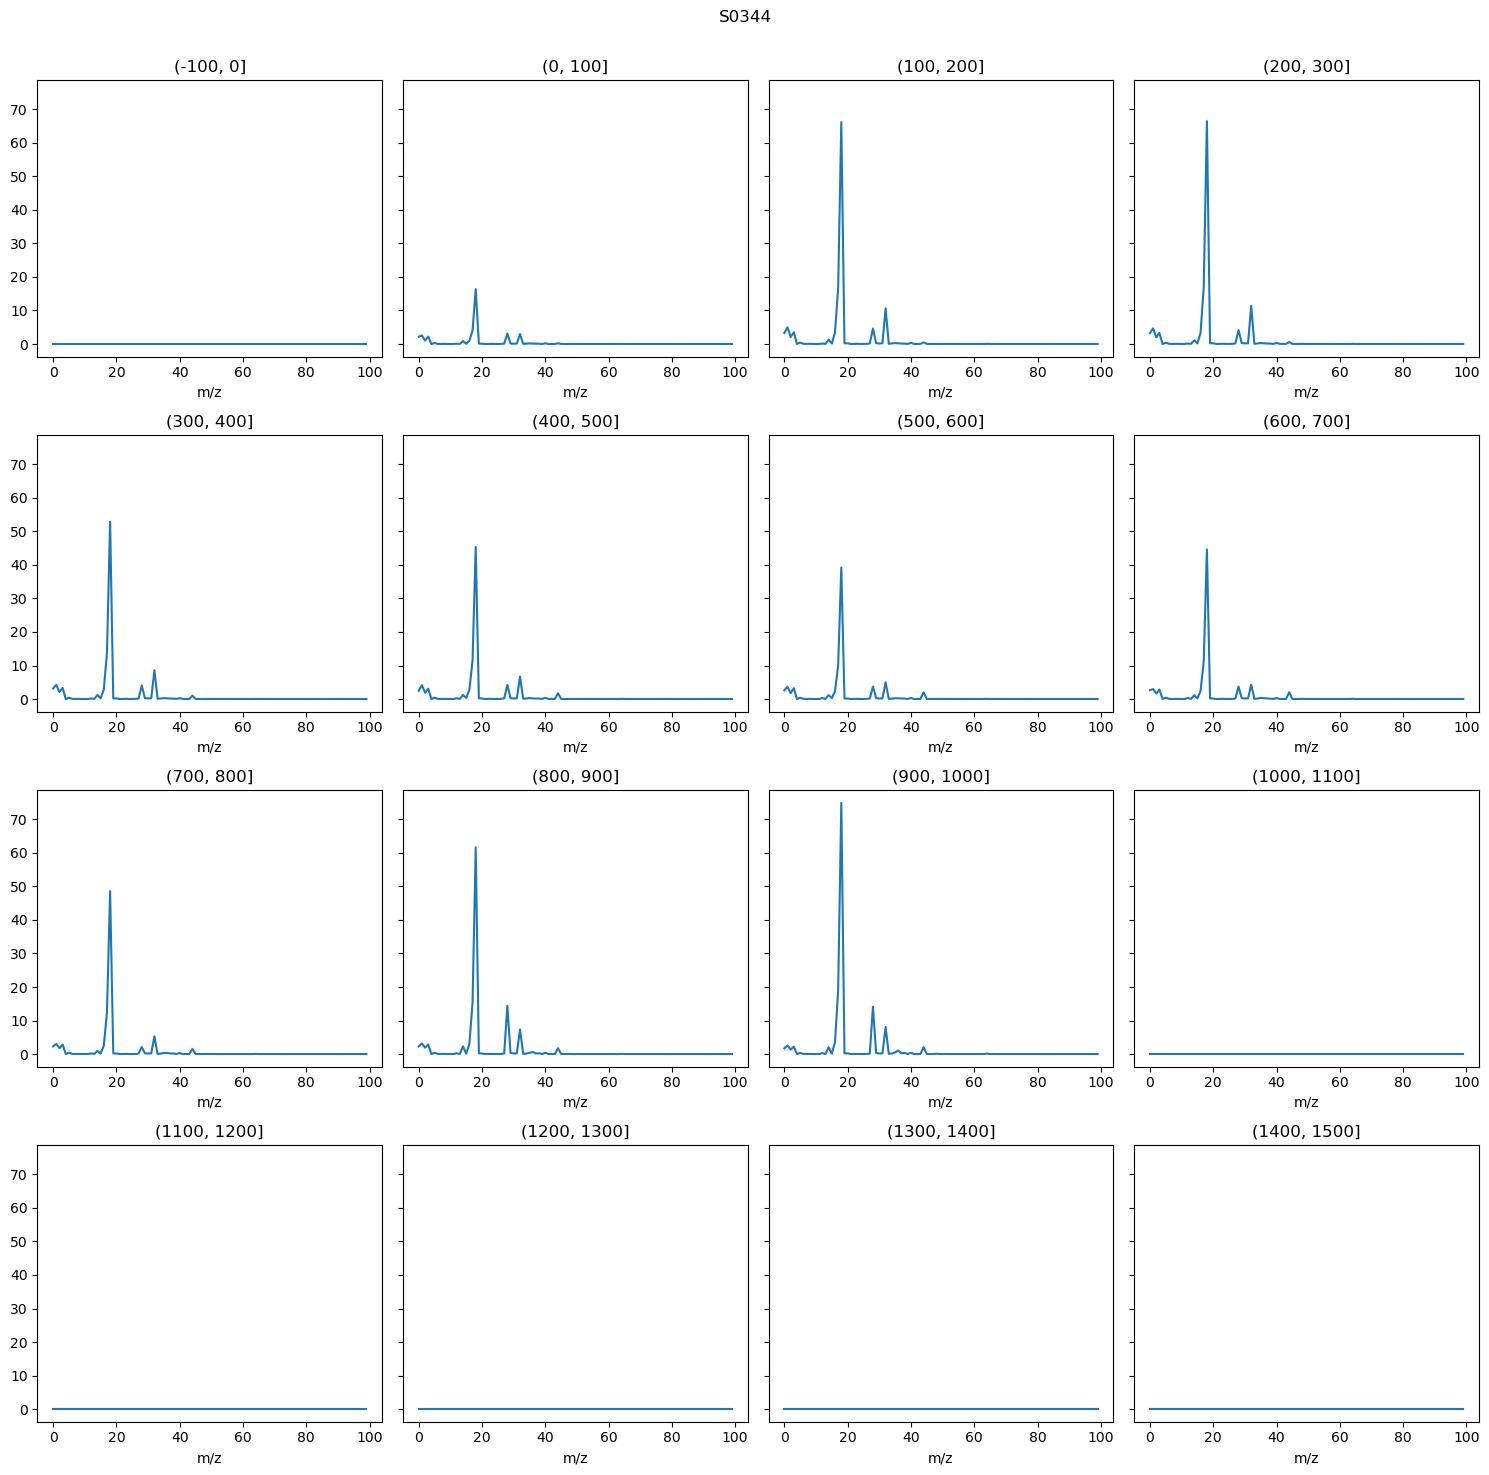

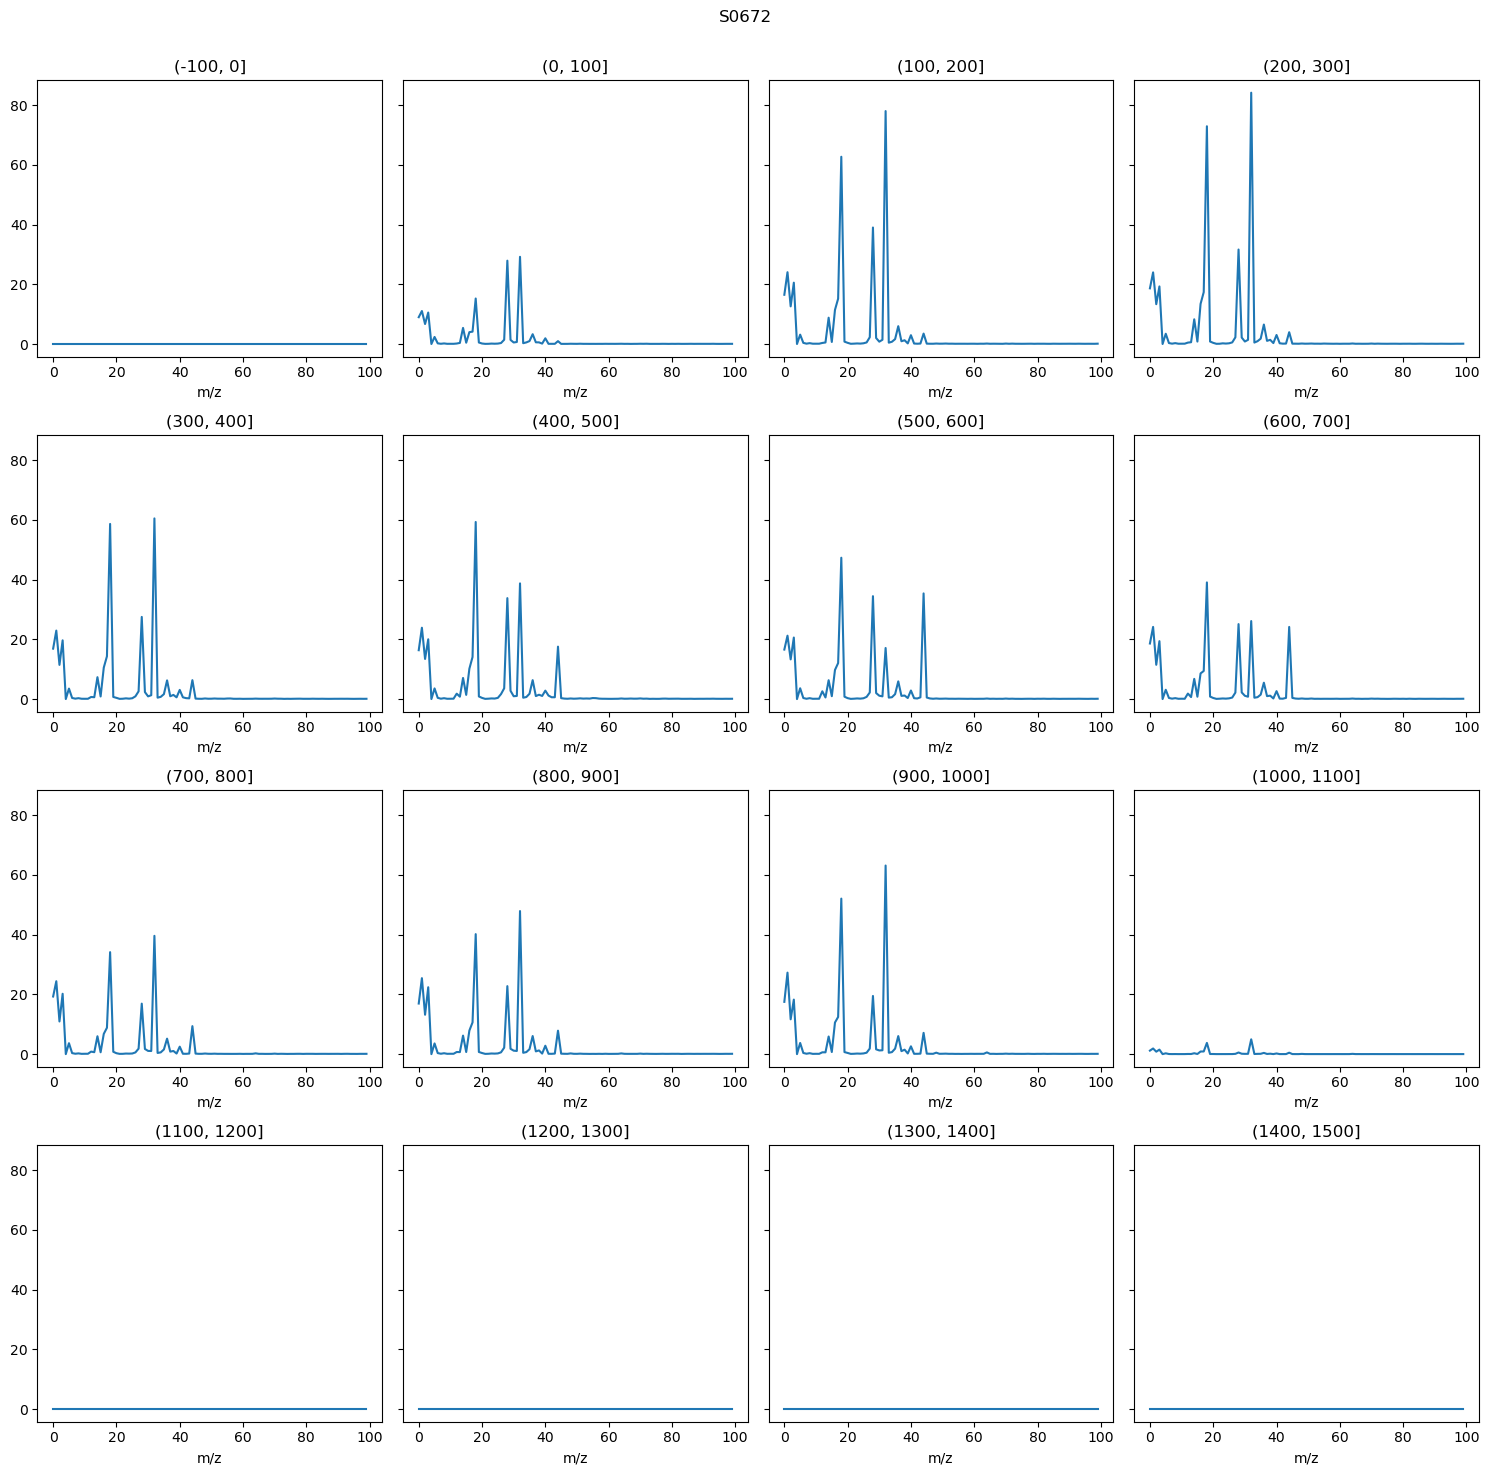

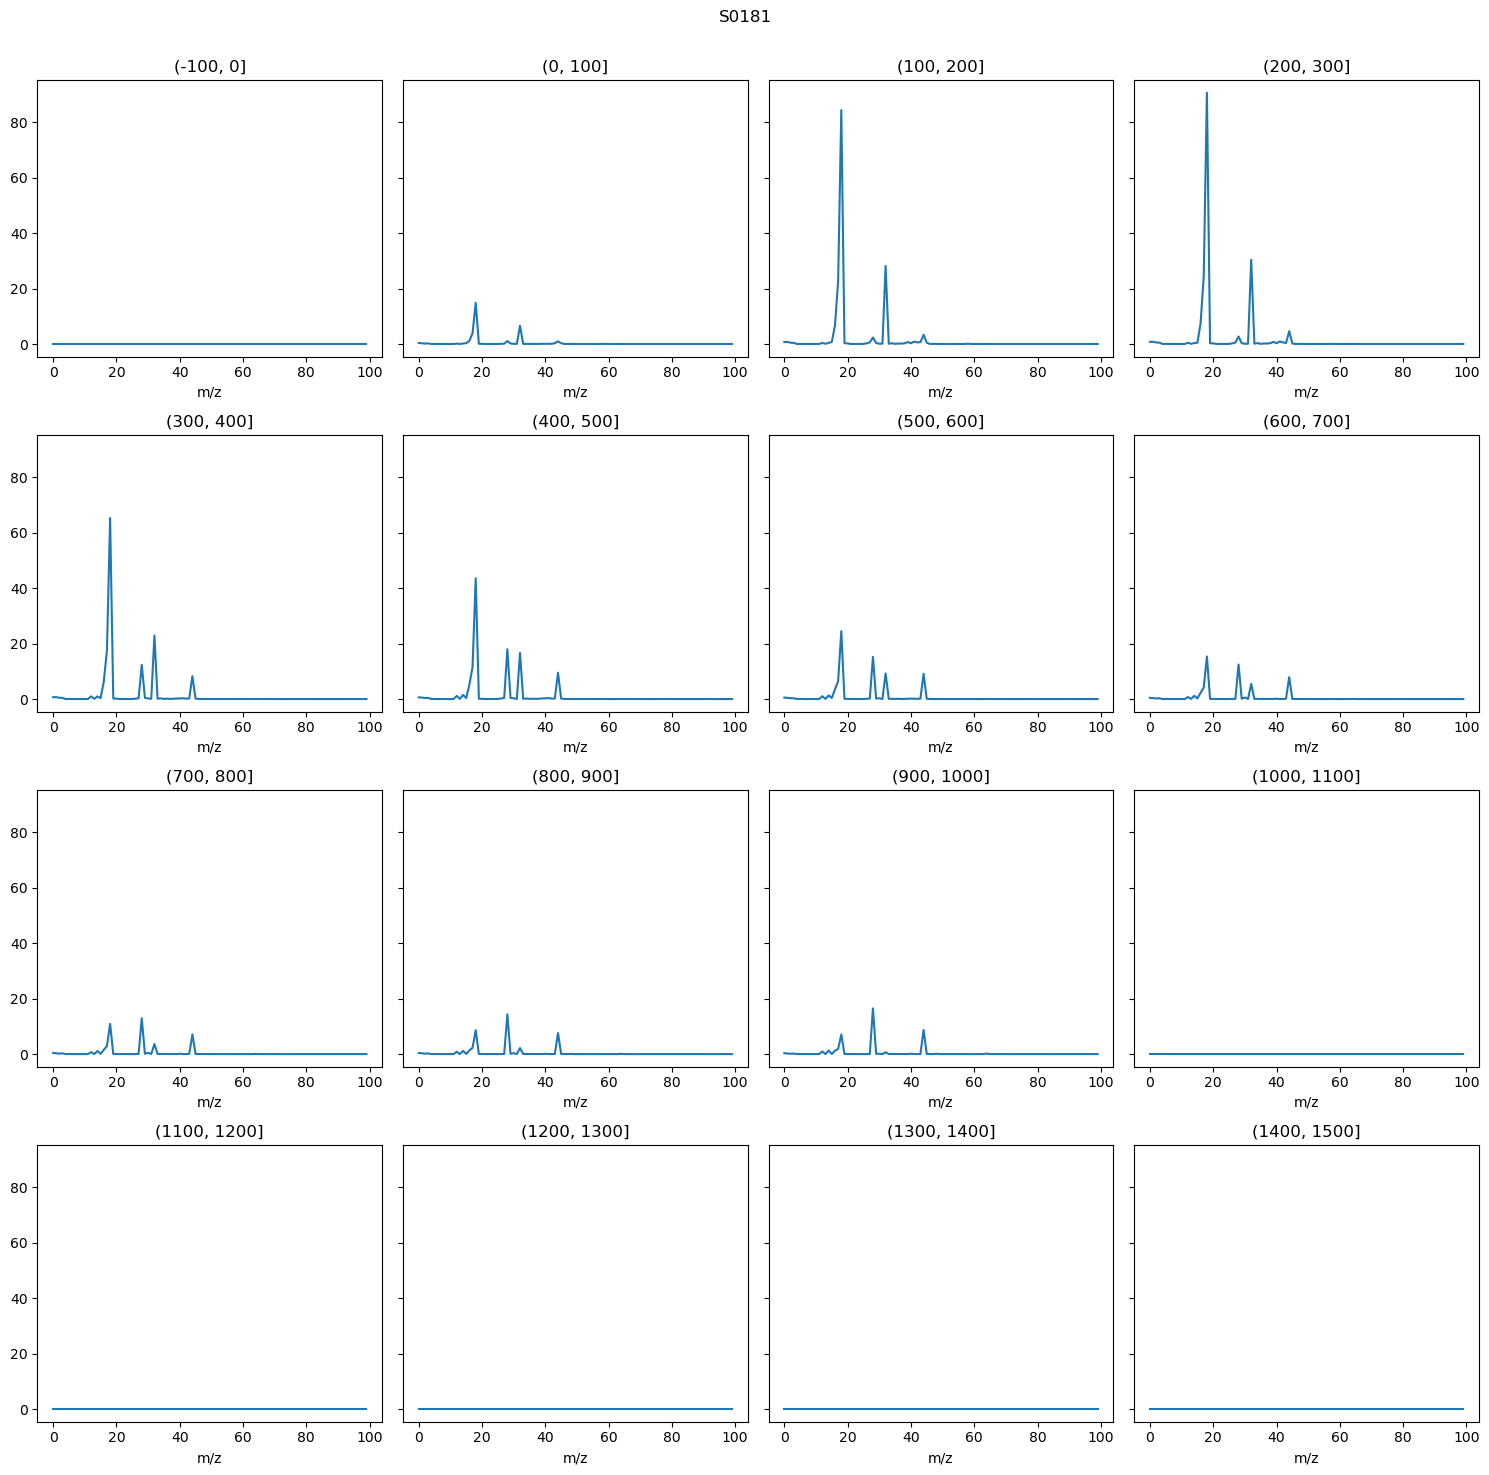

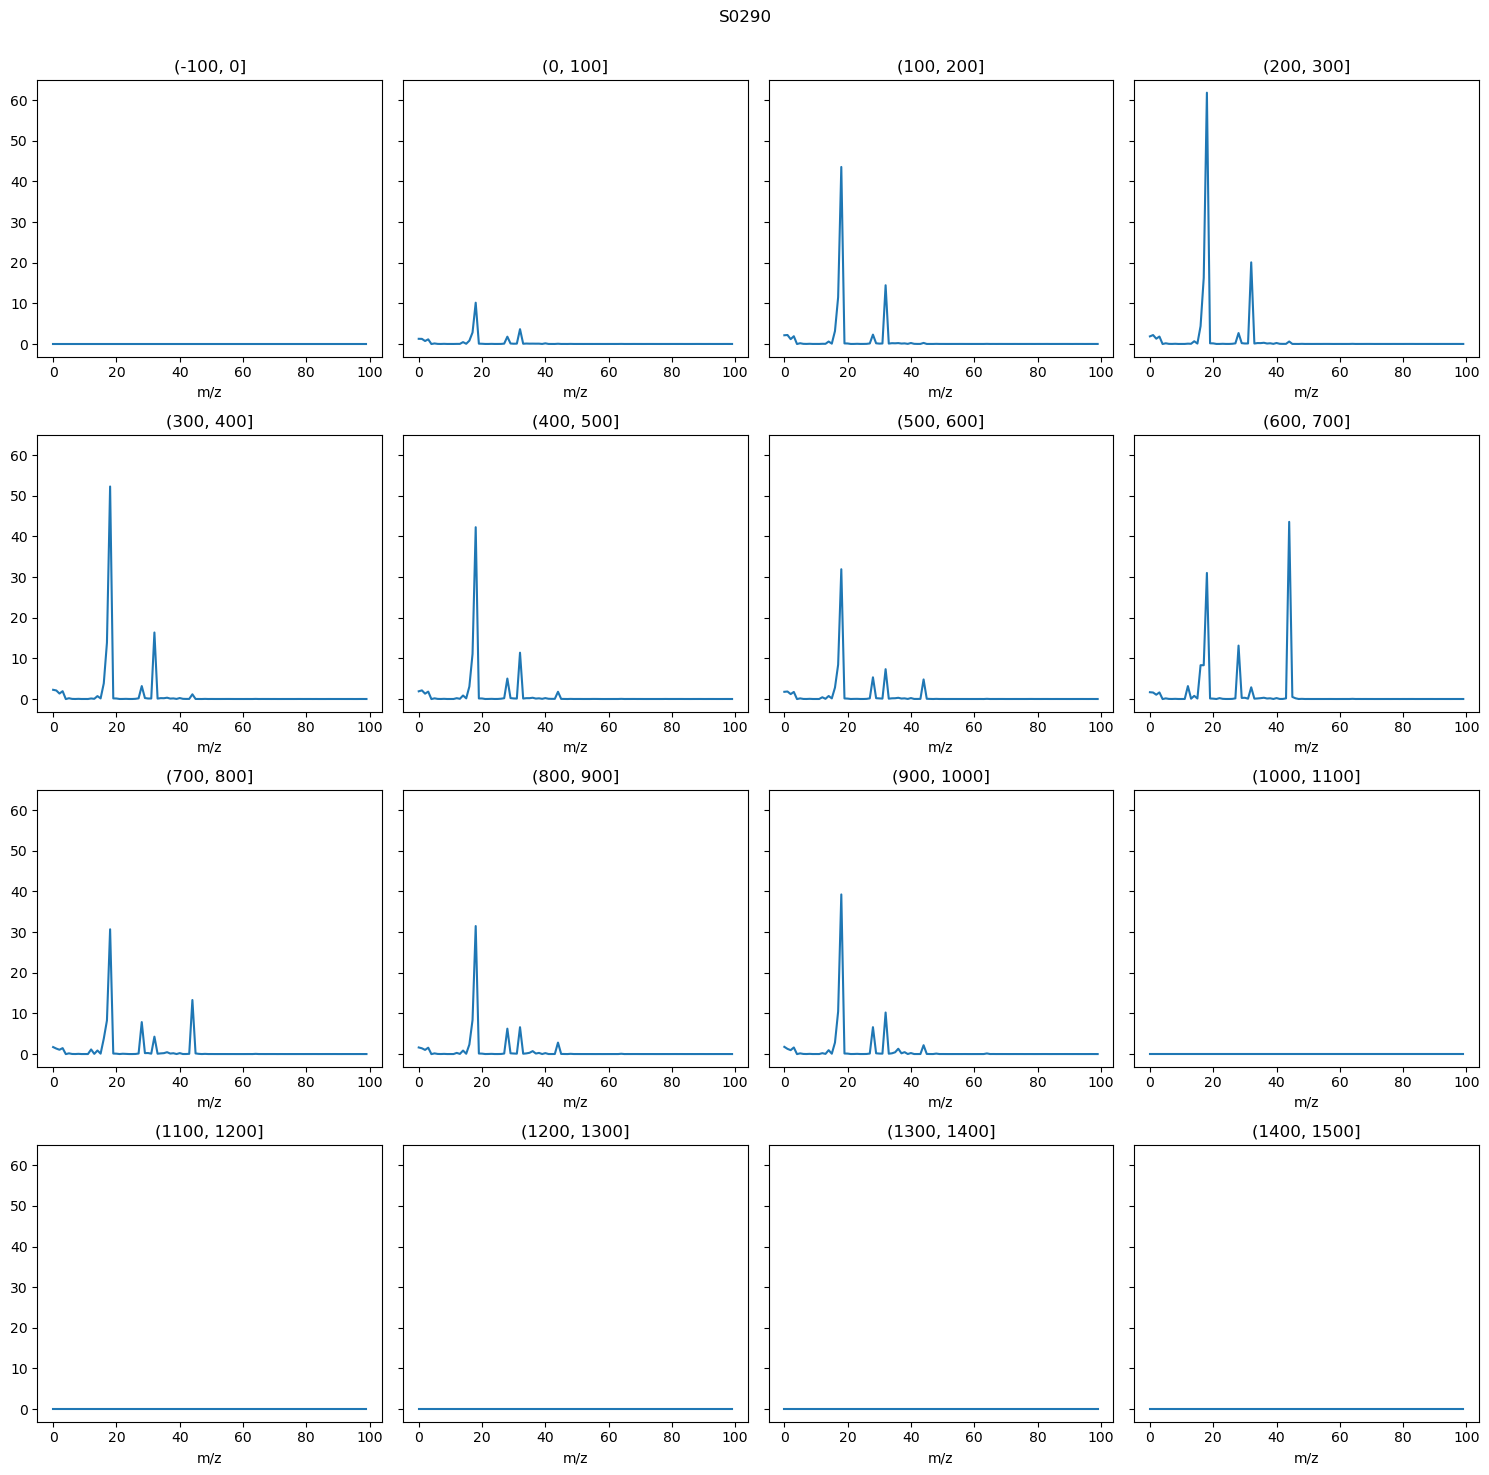

In [62]:
samples_list = random.sample(list(train_files.keys()),10)

# Create plots of the data in the dataframes above, for various samples

for sample in samples_list[:4]:

    fig, axs = plt.subplots(nrows=4,ncols=4,sharex=False,sharey=True,figsize = (15  ,15))

    plt.suptitle(sample+'\n'+'\n')

    for i in range(16):
        
        plt.subplot(4,4,i+1)

        plt.title(str(index_list[i]))



        plt.xlabel('m/z')

        plt.plot(np.linspace(0,99,100),DictAreas[sample].iloc[i])

        plt.tight_layout()

    

    plt.show()